# ML: K-means Clustering

## Setup

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-af345525-22e5-483d-b3c8-64e62f37d2a7;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 317ms :: artifacts dl 29ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


## Process S3 data with SageMaker Processing Job `PySparkProcessor`

In [4]:
!mkdir -p ./code

In [4]:
%%writefile ./code/process.py

import os
import logging
import argparse

# Import pyspark and build Spark session
from pyspark.sql.functions import *
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    parser.add_argument("--s3_output_bucket", type=str, help="s3 output bucket")
    parser.add_argument("--s3_output_prefix", type=str, help="s3 output prefix")
    parser.add_argument("--col_name_for_filtering", type=str, help="Name of the column to filter")
    parser.add_argument("--values_to_keep", type=str, help="comma separated list of values to keep in the filtered set")
    args = parser.parse_args()

    spark = SparkSession.builder.appName("PySparkApp").getOrCreate()
    logger.info(f"spark version = {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

   
    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    df = spark.read.parquet(args.s3_dataset_path, header=True)
    logger.info(f"finished reading files...")
    

    
    # filter the dataframe to only keep the values of interest
    vals = [s.strip() for s in args.values_to_keep.split(",")]
    df_filtered = df.where(col(args.col_name_for_filtering).isin(vals))
    
    # save the filtered dataframes so that these files can now be used for future analysis
    s3_path = f"s3://{args.s3_output_bucket}/{args.s3_output_prefix}"
    logger.info(f"going to write data for {vals} in {s3_path}")
    logger.info(f"shape of the df_filtered dataframe is {df_filtered.count():,}x{len(df_filtered.columns)}")
    df_filtered.write.mode("overwrite").parquet(s3_path)
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

Overwriting ./code/process.py


Now submit this code to SageMaker Processing Job.

In [5]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

# modify this comma separated list to choose the subreddits of interest
subreddits = "socialism, Economics"
configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

# the dataset contains data for these 3 years
year_list = [2021,2022,2023]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 2.44 s, sys: 364 ms, total: 2.81 s
Wall time: 2.71 s


In [6]:
%%time
print(f"going to filter comments data for year=2023")
s3_dataset_path_commments = f"s3://bigdatateaching/reddit-parquet/comments/year=2023/month=[1-3]/*.parquet" # "s3a://bigdatateaching/reddit/parquet/comments/yyyy=*/mm=*/*comments*.parquet"
output_prefix_data_comments = f"project/comments/yyyy=2023"
col_name_for_filtering = "subreddit"
subreddits = "soccer"
# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/process.py",
    arguments=[
        "--s3_dataset_path",
        s3_dataset_path_commments,
        "--s3_output_bucket",
        bucket,
        "--s3_output_prefix",
        output_prefix_data_comments,
        "--col_name_for_filtering",
        col_name_for_filtering,
        "--values_to_keep",
        subreddits,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)
# give some time for resources from this iterations to get cleaned up
# if we start the job immediately we could get insufficient resources error
time.sleep(60)

going to filter comments data for year=2023


INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-29-01-16-38-357


.........................................................................................................................!CPU times: user 538 ms, sys: 48.9 ms, total: 587 ms
Wall time: 11min 16s


## Read the data from S3

First read all the data of subreddit 'soccer' from 2023-01 to 2023-03.

In [4]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-094140871683/project/comments/yyyy=*


23/12/01 03:18:46 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 2,202,743x21
CPU times: user 2.44 s, sys: 369 ms, total: 2.8 s
Wall time: 1min 12s


In [7]:
comments.count()

2202743

Only keep the columns we need

In [5]:
# List of columns to drop
columns_to_drop = [
    "author_cakeday",
    "author_flair_css_class",
    "can_gild",
    "distinguished",
    "edited",
    "id",
    "is_submitter",
    "parent_id",
    "link_id",
    "permalink",
    "retrieved_on",
    "subreddit_id"
]

# Drop the columns from the DataFrame that are not needed
df = comments.drop(*columns_to_drop)

In [6]:
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- gilded: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)



In [7]:
df.show(5)

+---------------+-------------------+--------------------+----------------+-------------------+------+-----+--------+---------+
|         author|  author_flair_text|                body|controversiality|        created_utc|gilded|score|stickied|subreddit|
+---------------+-------------------+--------------------+----------------+-------------------+------+-----+--------+---------+
|     jordanhhh4|           :Fulham:|No idea why VAR c...|               0|2023-01-15 14:46:28|     0|    5|   false|   soccer|
|nonsenseSpitter|:Manchester_United:|Nice. \n\nNow som...|               0|2023-01-15 14:46:30|     0|   16|   false|   soccer|
|   NuclearEvo24|               null|I’d say it’s accu...|               0|2023-01-15 14:46:31|     0|   24|   false|   soccer|
|   widedickpapi|          :Chelsea:|Arsenal didn't of...|               0|2023-01-15 14:46:32|     0|  -14|   false|   soccer|
|     villiers19|        :Liverpool:|Awful back to bac...|               0|2023-01-15 14:46:33|     0|  

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

Filter the data and only keep those records where 'body' contains specific words relevant to soccer.

In [9]:
relevant_words = ['premier league', 'laliga', 'ligue 1', 'serie a', 'bundesliga', 'argentina', 'germany', 
            'spain', 'england', 'italy', 'france', 'brazil', 'world cup', 'fifa', 'mls', 'transfer',
           'goat', 'champions league', 'var', 'europa', 'golden', 'ballon', 'derby', 'coach']

In [46]:
# relevant_words = ['premier league', 'laliga', 'ligue 1', 'serie a', 'bundesliga', 'argentina', 'germany', 
#                   'spain', 'england', 'italy', 'france', 'brazil', 'world cup', 'fifa', 'mls', 'transfer',
#                   'goat', 'champions league', 'var', 'europa', 'golden', 'ballon', 'derby', 'tactic', 'formation', 
#                   'playstyle', 'strategy', 'lineup', 'set-piece', 'defense', 'offense', 'pressing', 
#                   'counter-attack', 'tiki-taka', 'tikitaka', '433', '442', '4-3-3', '4-4-2',
#                   'signing', 'contract', 'bid', 'deal', 'release clause', 'agent', 'loan',
#                   'goal', 'assist', 'save', 'tackle', 'dribble', 'performance', 'man of the match', 'rating', 'brace', 'hat trick',
#                   'rankings', 'top scorer', 'best midfielder', 'best defender' 'leaderboard', 'award',
#                   'manager', 'coach', 'substitution', 'selection', 'bench', 'press conference']

In [10]:
# Create a filter condition for each keyword
filter_condition = F.lower(F.col('body')).like(f'%{relevant_words[0]}%')
for word in relevant_words[1:]:
    filter_condition = filter_condition | F.lower(F.col('body')).like(f'%{word}%')


In [11]:
filtered_df = df.filter(filter_condition)

In [12]:
filtered_df.count()

179937

In [15]:
filtered_df.cache

<bound method DataFrame.cache of DataFrame[author: string, author_flair_text: string, body: string, controversiality: bigint, created_utc: timestamp, gilded: bigint, score: bigint, stickied: boolean, subreddit: string]>

Create numeric variables based on certain keywords about soccer.

In [16]:
keywords = ['premier league', 'laliga', 'ligue 1', 'serie a', 'bundesliga', 'argentina', 'germany', 
            'spain', 'england', 'italy', 'france', 'brazil', 'world cup', 'fifa', 'mls', 'transfer',
           'goat', 'champions league', 'var', 'europa', 'golden', 'ballon', 'derby', 'coach']

In [17]:
def count_keyword(text, keyword):
    return text.lower().count(keyword)

for keyword in keywords:
    count_keyword_udf = udf(lambda text: count_keyword(text, keyword), IntegerType())
    filtered_df = filtered_df.withColumn(keyword.replace(" ", "_"), count_keyword_udf(df['body']))

In [18]:
filtered_df.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- gilded: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- premier_league: integer (nullable = true)
 |-- laliga: integer (nullable = true)
 |-- ligue_1: integer (nullable = true)
 |-- serie_a: integer (nullable = true)
 |-- bundesliga: integer (nullable = true)
 |-- argentina: integer (nullable = true)
 |-- germany: integer (nullable = true)
 |-- spain: integer (nullable = true)
 |-- england: integer (nullable = true)
 |-- italy: integer (nullable = true)
 |-- france: integer (nullable = true)
 |-- brazil: integer (nullable = true)
 |-- world_cup: integer (nullable = true)
 |-- fifa: integer (nullable = true)
 |-- mls: integer (nullable = true)
 |-- transfer: integer (nul

In [19]:
numeric_columns = [column for (column, dtype) in filtered_df.dtypes if dtype == 'int']

sum_expressions = [F.sum(column).alias('sum_' + column) for column in numeric_columns]

sums = filtered_df.agg(*sum_expressions)

sums.show()

+------------------+----------+-----------+-----------+--------------+-------------+-----------+---------+-----------+---------+----------+----------+-------------+--------+-------+------------+--------+--------------------+-------+----------+----------+----------+---------+---------+
|sum_premier_league|sum_laliga|sum_ligue_1|sum_serie_a|sum_bundesliga|sum_argentina|sum_germany|sum_spain|sum_england|sum_italy|sum_france|sum_brazil|sum_world_cup|sum_fifa|sum_mls|sum_transfer|sum_goat|sum_champions_league|sum_var|sum_europa|sum_golden|sum_ballon|sum_derby|sum_coach|
+------------------+----------+-----------+-----------+--------------+-------------+-----------+---------+-----------+---------+----------+----------+-------------+--------+-------+------------+--------+--------------------+-------+----------+----------+----------+---------+---------+
|             14318|      2199|       3179|       6389|          7000|         8856|       6659|     9194|      15047|     7260|      9692|   

## K-means Clustering

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [21]:
# Create a feature vector
vec_assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
df_kmeans = vec_assembler.transform(filtered_df)

In [22]:
# Standardize
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
df_kmeans = scaler.fit(df_kmeans).transform(df_kmeans)

23/12/01 03:24:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [23]:
silhouette_list = []
wssse_list = []
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', metricName='silhouette')

In [24]:
for k in range(2, 10):  
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(df_kmeans)
    predictions = model.transform(df_kmeans)
    
    # Compute silhouette value
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append((k, silhouette))
    
    # Compute wssse
    wssse = model.summary.trainingCost 
    wssse_list.append((k, wssse))

In [25]:
silhouette_list

[(2, 0.32783772637913106),
 (3, 0.3430911724763658),
 (4, 0.3549922730829993),
 (5, 0.379673383358212),
 (6, 0.2510590721666612),
 (7, 0.3717185916387078),
 (8, 0.2539237282166197),
 (9, -0.012854257183435969)]

In [26]:
wssse_list

[(2, 4150965.514208846),
 (3, 3992948.097832774),
 (4, 3865063.0998728215),
 (5, 3687018.931070642),
 (6, 3557802.3627242665),
 (7, 3518179.5460969284),
 (8, 3479616.044585369),
 (9, 3249163.1108469595)]

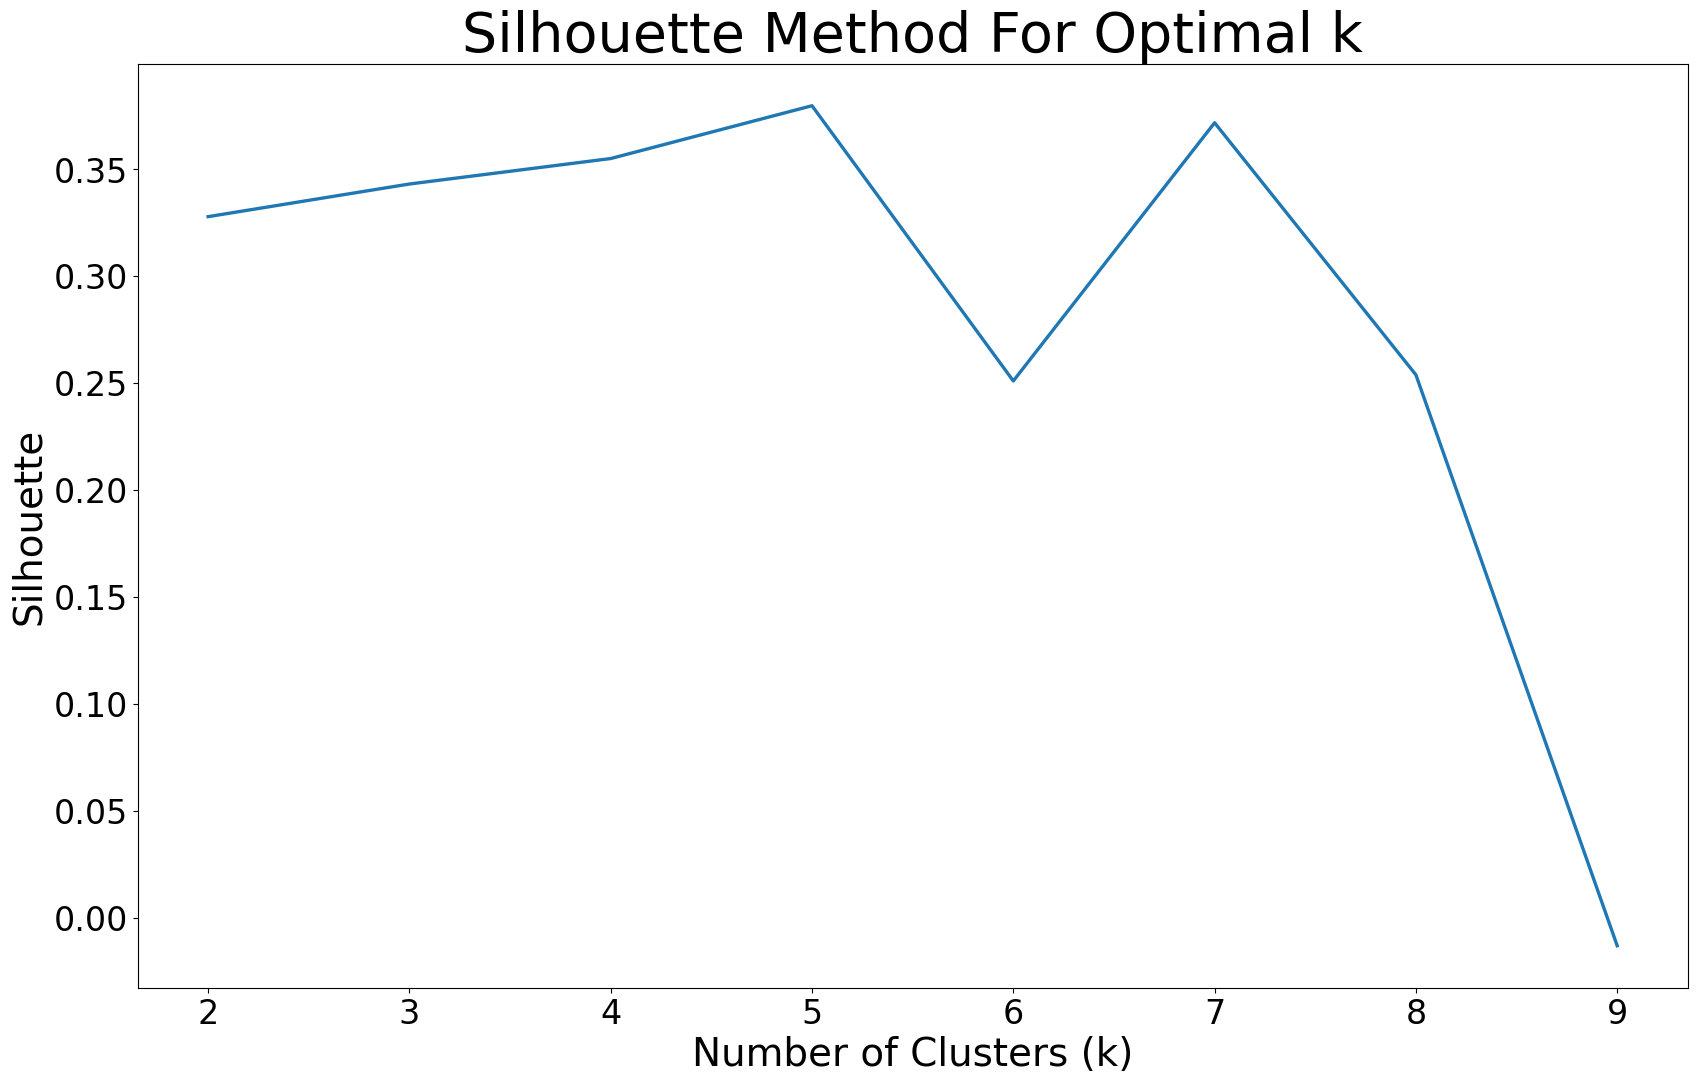

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

silhouette_df = pd.DataFrame(silhouette_list, columns=['k', 'silhouette'])

sns.reset_defaults()
plt.rcdefaults()

# Create the lineplot of Silhouette values
plt.figure(figsize=(20, 12))
sns.lineplot(data=silhouette_df, x='k', y='silhouette', linewidth=2.4)
plt.title('Silhouette Method For Optimal k', fontsize=40)
plt.xlabel('Number of Clusters (k)', fontsize=28)
plt.ylabel('Silhouette', fontsize=28)
plt.tick_params(axis='both', labelsize=24)
plt.xticks(silhouette_df['k'])
plt.savefig('./silhouette_plot.png')
plt.show()

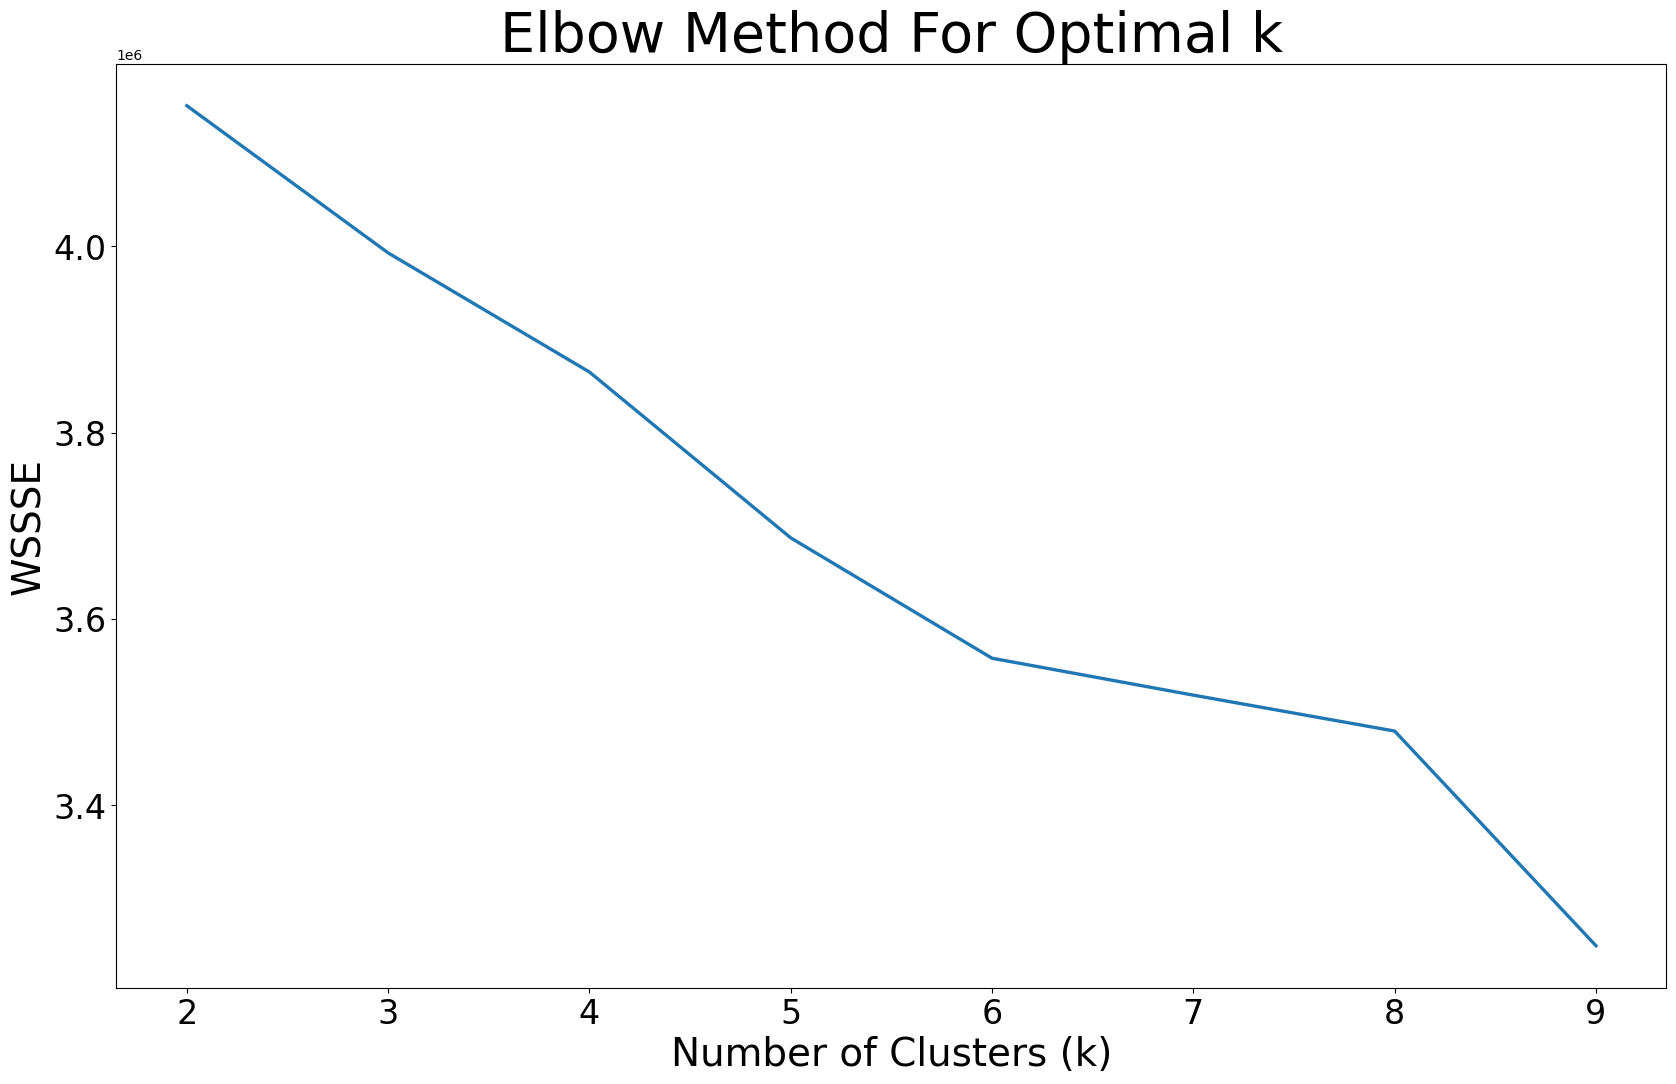

In [28]:
wssse_df = pd.DataFrame(wssse_list, columns=['k', 'wssse'])

sns.reset_defaults()
plt.rcdefaults()

# Create the lineplot of WSSSE values
plt.figure(figsize=(20, 12))
sns.lineplot(data=wssse_df, x='k', y='wssse', linewidth=2.4)
plt.title('Elbow Method For Optimal k', fontsize=40)
plt.xlabel('Number of Clusters (k)', fontsize=28)
plt.ylabel('WSSSE', fontsize=28)
plt.tick_params(axis='both', labelsize=24)
plt.xticks(wssse_df['k'])
plt.savefig('./elbow_plot.png')
plt.show()

In [29]:
# Perform K-means clustering
kmeans = KMeans(featuresCol='scaledFeatures', k=5) 
model = kmeans.fit(df_kmeans)

In [50]:
predictions = model.transform(df_kmeans)
# predictions.select('prediction').show()

In [53]:
cluster_count = predictions.groupBy('prediction').count().orderBy('prediction', ascending=True)
cluster_count.show()

+----------+------+
|prediction| count|
+----------+------+
|         0|162947|
|         1|  5885|
|         2|  5859|
|         3|  2826|
|         4|  2420|
+----------+------+



In [57]:
cluster_count.write.csv('./cluster_count.csv', header=True, mode='overwrite')

In [34]:
df_with_cluster = df_kmeans.join(predictions.select('prediction', 'scaledFeatures'), on='scaledFeatures')


In [36]:
cluster_averages_dict = {}

# Iterate over each cluster and calculate averages
for i in range(5): 
    cluster_df = df_with_cluster.filter(F.col('prediction') == i)
    averages = cluster_df.select([F.avg(column).alias(column) for column in numeric_columns])
    row = averages.first().asDict()
    cluster_averages_dict[f'Cluster_{i}'] = row

# Convert the dictionary to a DataFrame and transpose
cluster_averages_df = spark.createDataFrame(pd.DataFrame(cluster_averages_dict))
cluster_averages_df = cluster_averages_df.toPandas().transpose()

In [38]:
cluster_averages_df.columns = numeric_columns

In [39]:
cluster_averages_df

,premier_league,laliga,ligue_1,serie_a,bundesliga,argentina,germany,spain,england,italy,...,mls,transfer,goat,champions_league,var,europa,golden,ballon,derby,coach
Cluster_0,0.057581,0.001013,0.000000e+00,0.009007,0.011191,0.013012,7.189355e-10,0.017055,0.053826,0.008575,...,3.174159e-03,0.170220,1.367934e-02,0.036679,0.358101,0.000000e+00,0.002436,0.000000e+00,4.970002e-03,0.088806
Cluster_1,0.000302,0.000006,1.016195e-07,0.000060,0.000047,0.000003,2.184820e-06,0.000057,0.000046,0.000012,...,7.621465e-07,0.000103,8.129563e-07,0.007569,0.000107,1.001732e+00,0.000001,1.016195e-07,2.083200e-06,0.000096
Cluster_2,0.000061,0.000003,5.147305e-07,0.000038,0.001288,0.000218,1.004001e+00,0.002007,0.003658,0.002406,...,4.220790e-06,0.000081,1.173586e-05,0.000059,0.000248,6.176766e-07,0.000007,1.029461e-07,5.456143e-06,0.000202
Cluster_3,0.001160,0.000059,1.003235e+00,0.003935,0.004883,0.000021,1.774535e-05,0.000023,0.000126,0.000021,...,4.164726e-05,0.000564,1.810750e-05,0.000366,0.000036,4.128511e-05,0.000010,7.243002e-07,3.983651e-06,0.000140
Cluster_4,0.000055,0.000006,3.741672e-05,0.000024,0.000026,0.000045,2.260593e-05,0.000052,0.000029,0.000015,...,1.169272e-06,0.000884,2.864718e-04,0.000702,0.000279,5.456605e-06,0.000575,1.001874e+00,3.897575e-07,0.000080


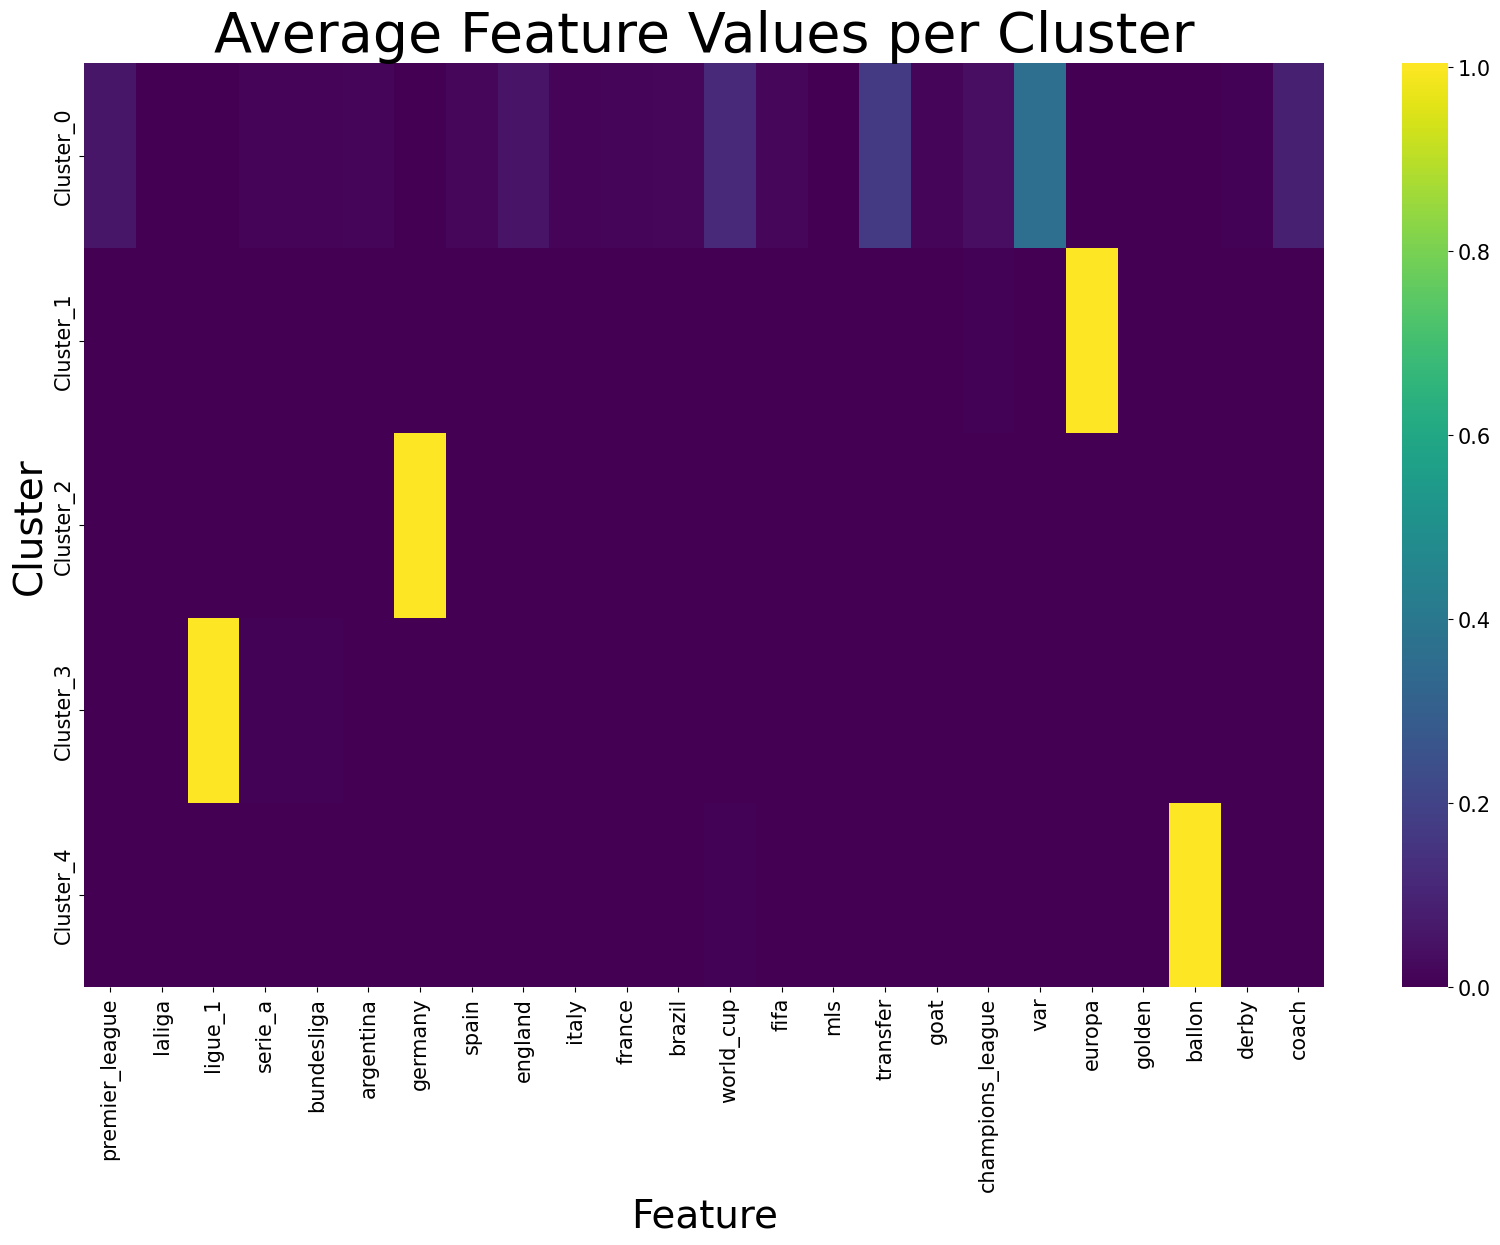

In [69]:
sns.reset_defaults()
plt.rcdefaults()

# Create a heatmap for average feature values per cluster
plt.figure(figsize=(20, 12))
ax = sns.heatmap(cluster_averages_df, annot=False, fmt=".2f", cmap='viridis')

plt.title('Average Feature Values per Cluster', fontsize=40)
plt.xlabel('Feature', fontsize=28)
plt.ylabel('Cluster', fontsize=28)
plt.tick_params(axis='both', labelsize=15)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)  

plt.savefig('./cluster_feature_heatmap.png')
plt.show()